# Agenda for today:
<br>
## General introduction:
### 10:00 – 10:30. Introduction to the Challenge, including top tips.
### 1, Introduction of the problem
### 2, Data inspection and precessing for fast sharing
### 3, <span style="color:red"> Sample answer requirement</span>
<br>
<br>
## Advanced problem solving:
### 14:00 - 14:30. tips on how to improve your algorithms.
### 1, Machine learning in weather prediction
### 2, Route planning

# Problem Description:

<p>The scenario is set in the future—in the year of 2050, a world where the invention of “anti-gravity engines” has led to the creation of unmanned balloons as the preferred logistics solution. However, because of the UK’s complex meteorological conditions, the balloons are occasionally delayed, damaged or even destroyed by extreme weather conditions causing disruption and loss. The contestants will be challenged to create algorithms that can plan flight routes for these balloons to navigate the endless variation and changeable nature across the UK to optimize their delivery schedules and costs.</p>


# Objectives:
## Develop an efficient navigation algorithm for cargo balloons while avoiding volatile weathers
### <li>10 balloons set out daily from Hyde Park London to 10 destination cities in Britain. <span style="color:red">However,if the wind is too strong, cargo balloons will be destroyed (wind speed >= 15)</span></li>
### <li>The Met Office runs 10 different forecast models every day, However, the accuracy of these predcitions is not perfect</li>
### <li>For simplification,we divided the coverage area into blocks,Each block is expressed by an x-axis coordinate and a y-axis coordinate (x,y)</li>
### <li><span style="color:red">The travel time across each block is fixed by two minutes</span></li>
### <li>Balloons can move <span style="color:red">up, down, left, and right from the current block or stay at the current block, but cannot move diagonally.</span></li>
### <li><span style="color:red">The travel duration is restricted to 18 hours [03:00-21:00)</span></li>
### <li>The final score on the leaderboard will be the total amount of travel time in minutes for all successful balloon flights, plus the total amount of penalties. The lowest score wins the leaderboard. </li>

### <li><span style="color:red">The objective function = 24 $\times$ 60 $\times$ number of crashes + total travel minutes of successfully arrived balloons</span></li>

# Where is Leaderboard?

<img src="../leaderboard.png" alt>(https://tianchi.aliyun.com/competition/rankingList.htm?spm=5176.100067.5678.4.15b5be18jYcamj&raceId=231645)


# Prizes:

### The Hackathon – Top of the leaderboard by the end of the day:
#### <li>1st prize: 800 dollars</li>
#### <li>2nd prize: 500 dollars</li>
#### <li>3rd prize: 300 dollars</li>
#### <span style="color:red">Bonus Prize - Top of the UK event attendees* leaderboard by 31st January:</span>
#### <span style="color:red">1st prize: 1,000 dollars</span>
<br>
#### Future Challenge – Overall contest winners:
####  <li>1st prize: 8,000 dollars</li>
#### <li> 2nd prize: 5,000 dollars</li>
#### <li>3rd prize: 3,000 dollars</li>
#### Plus a trip to Barcelona to attend the winners’ ceremony at the GSMA Mobile World Congress in Barcelona and a week long visit to the world-renowned Met Office Informatics Lab.

# Where to download the data?

<img src="../hachaton_intro1.png" alt>(https://tianchi.aliyun.com/competition/information.htm?spm=5176.100067.5678.2.5cc1c17ebabUi9&raceId=231622)

# Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import h5py

/home/anog/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
citydata = pd.read_csv('CityData.csv')
#train = pd.read_csv('ForecastDataforTraining_201712.csv') #4GB
#test = pd.read_csv('ForecastDataforTesting_201712.csv') #4GB
#labeldata = pd.read_csv('In_situMeasurementforTraining_201712.csv')

In [4]:
# corrdinate for each city
citydata

,cid,xid,yid
0,0,142,328
1,1,84,203
2,2,199,371
3,3,140,234
4,4,236,241
5,5,315,281
6,6,358,207
7,7,363,237
8,8,423,266
9,9,125,375


In [5]:
# training samples with 10 different models
! head ForecastDataforTraining_201712.csv

xid,yid,date_id,hour,model,wind
1,1,1,3,1,13.8
1,1,1,3,2,12.8
1,1,1,3,3,10.4
1,1,1,3,4,11.1
1,1,1,3,5,13.2
1,1,1,3,6,13.1
1,1,1,3,7,12.6
1,1,1,3,8,11.2
1,1,1,3,9,14.1


In [6]:
# testing samples with 10 different models
! tail ForecastDataforTraining_201712.csv

548,421,5,20,1,7.42
548,421,5,20,2,4.91
548,421,5,20,3,4.47
548,421,5,20,4,8.34
548,421,5,20,5,12.9
548,421,5,20,6,9.51
548,421,5,20,7,7
548,421,5,20,8,10.7
548,421,5,20,9,6.99
548,421,5,20,10,9.48


In [2]:
# Training labels with real wind speed
! head In_situMeasurementforTraining_201712.csv

xid,yid,date_id,hour,wind
1,1,1,3,12.8
1,2,1,3,12.8
1,3,1,3,12.6
1,4,1,3,12.1
1,5,1,3,11.6
1,6,1,3,11.1
1,7,1,3,10.7
1,8,1,3,10.5
1,9,1,3,10.6


In [8]:
train = np.zeros((5,20-3+1,11,548,421)) #initialize an empty 5D tensor
print ('start processing traindata')
with open('ForecastDataforTraining_201712.csv') as trainfile:
    for index,line in enumerate(trainfile):
        #traindata format
        #xid,yid,date_id,hour,model,wind
        #1,1,1,3,1,13.8

        traindata = line.split(',')
        try:
            x = int(traindata[0])
            y = int(traindata[1])
            d = int(traindata[2])
            h = int(traindata[3])
            m = int(traindata[4])
            w = float(traindata[5])
            train[d-1,h-3,m-1,x-1,y-1] = w # write values into tensor
            
            if index%1000000==0:
                print ('%i lines has been processed' %(index))
        except ValueError:
            print ("found line with datatype error! skip this line")
            continue
            
print ('start processing labeldata'        )    
with open('In_situMeasurementforTraining_201712.csv') as labelfile:
    for index,line in enumerate(labelfile):        
        #labeldata format
        #xid,yid,date_id,hour,wind
        #1,1,1,3,12.8
        labeldata = line.split(',')
        try:          
            lx = int(labeldata[0])
            ly = int(labeldata[1])
            ld = int(labeldata[2])
            lh = int(labeldata[3])
            lw = float(labeldata[4])
            train[ld-1,lh-3,10,lx-1,ly-1] = lw
            if index%1000000==0:
                print( '%i lines has been processed' %(index))
        except ValueError:
            print ("found line with datatype error! skip this line")
            continue

start processing traindata
found line with datatype error! skip this line
1000000 lines has been processed
2000000 lines has been processed
3000000 lines has been processed
4000000 lines has been processed
5000000 lines has been processed
6000000 lines has been processed
7000000 lines has been processed
8000000 lines has been processed
9000000 lines has been processed
10000000 lines has been processed
11000000 lines has been processed
12000000 lines has been processed
13000000 lines has been processed
14000000 lines has been processed
15000000 lines has been processed
16000000 lines has been processed
17000000 lines has been processed
18000000 lines has been processed
19000000 lines has been processed
20000000 lines has been processed
21000000 lines has been processed
22000000 lines has been processed
23000000 lines has been processed
24000000 lines has been processed
25000000 lines has been processed
26000000 lines has been processed
27000000 lines has been processed
28000000 lines ha

In [9]:
! head ForecastDataforTesting_201712.csv

xid,yid,date_id,hour,model,wind
1,1,6,3,1,10
1,1,6,3,2,8.61
1,1,6,3,3,9.18
1,1,6,3,4,14.9
1,1,6,3,5,7.85
1,1,6,3,6,13.4
1,1,6,3,7,10.2
1,1,6,3,8,10
1,1,6,3,9,2.91


In [10]:
! tail ForecastDataforTesting_201712.csv

548,421,10,20,1,22.6
548,421,10,20,2,24.9
548,421,10,20,3,24.6
548,421,10,20,4,26.8
548,421,10,20,5,22.4
548,421,10,20,6,22.4
548,421,10,20,7,24.6
548,421,10,20,8,23
548,421,10,20,9,22.3
548,421,10,20,10,19.6


In [13]:
test = np.zeros((5,20-3+1,10,548,421))
print ('start processing testdata')
with open('ForecastDataforTesting_201712.csv') as testfile:
    for index,line in enumerate(testfile):
        #testdata format
        #xid,yid,date_id,hour,model,wind
        #1,1,1,3,1,13.8

        testdata = line.split(',')
        try:
            x = int(testdata[0])
            y = int(testdata[1])
            d = int(testdata[2])
            h = int(testdata[3])
            m = int(testdata[4])
            w = float(testdata[5])
            test[d-6,h-3,m-1,x-1,y-1] = w
            
            if index%1000000==0:
                print ('%i lines has been processed' %(index))
        except ValueError:
            print ("found line with datatype error! skip this line")
            continue

start processing testdata
found line with datatype error! skip this line
1000000 lines has been processed
2000000 lines has been processed
3000000 lines has been processed
4000000 lines has been processed
5000000 lines has been processed
6000000 lines has been processed
7000000 lines has been processed
8000000 lines has been processed
9000000 lines has been processed
10000000 lines has been processed
11000000 lines has been processed
12000000 lines has been processed
13000000 lines has been processed
14000000 lines has been processed
15000000 lines has been processed
16000000 lines has been processed
17000000 lines has been processed
18000000 lines has been processed
19000000 lines has been processed
20000000 lines has been processed
21000000 lines has been processed
22000000 lines has been processed
23000000 lines has been processed
24000000 lines has been processed
25000000 lines has been processed
26000000 lines has been processed
27000000 lines has been processed
28000000 lines has

In [ ]:
train.shape

In [ ]:
train

In [14]:
# write numpy arrary tensor into h5 format
h5f = h5py.File('METdata.h5', 'w')
h5f.create_dataset('train', data=train)
h5f.create_dataset('test', data=test)
h5f.close()

In [3]:
# read h5 format back to numpy array
h5f = h5py.File('METdata.h5', 'r')
train = h5f['train'][:]
test = h5f['test'][:]
h5f.close()

In [7]:
print 548*421*18*5*10
print train.shape

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(548*421*18*5*10)? (<ipython-input-7-b71edc96bb5c>, line 1)

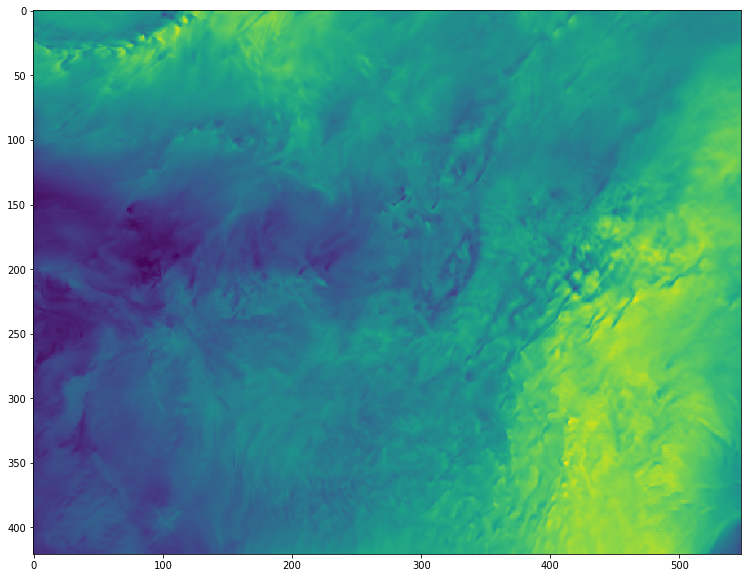

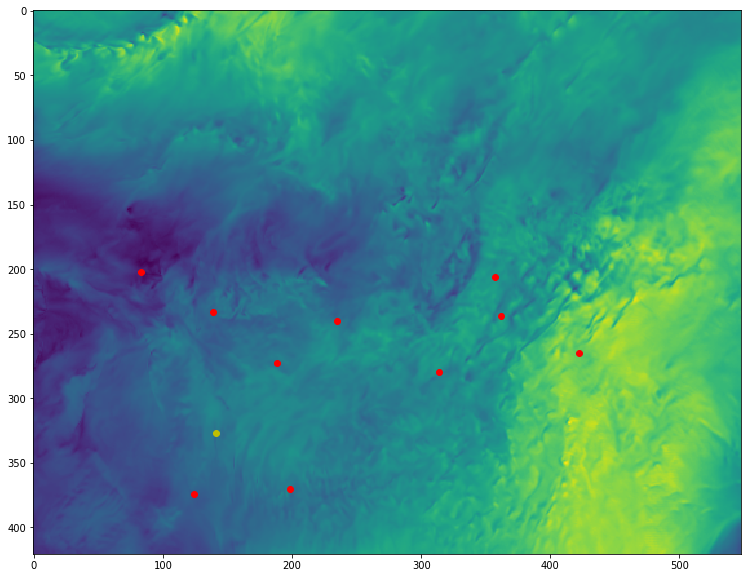

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(train[0,0,0,:,:].T)
for c,x,y in zip(citydata.cid,citydata.xid,citydata.yid):
    if c == 0:
        plt.plot(x-1,y-1,'yo')
    else:
        plt.plot(x-1,y-1,'ro')
plt.show()

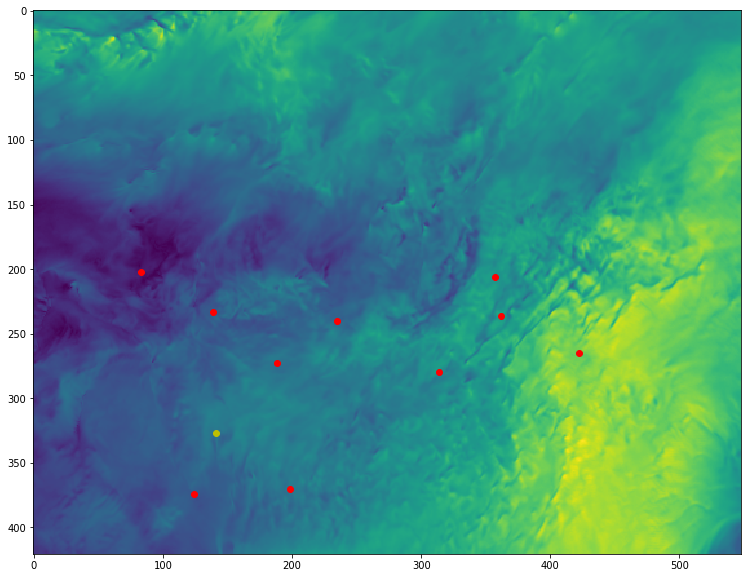

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(train[0,0,10,:,:].T)
for c,x,y in zip(citydata.cid,citydata.xid,citydata.yid):
    if c == 0:
        plt.plot(x-1,y-1,'yo')
    else:
        plt.plot(x-1,y-1,'ro')
plt.show()

In [ ]:
train[0,0,10,:,:].T-train[0,0,0,:,:].T

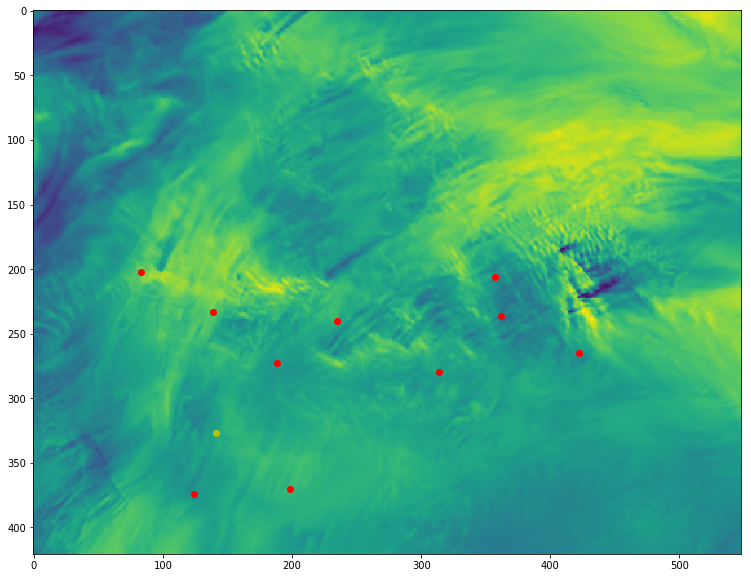

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(test[0,0,1,:,:].T)
for c,x,y in zip(citydata.cid,citydata.xid,citydata.yid):
    if c == 0:
        plt.plot(x-1,y-1,'yo')
    else:
        plt.plot(x-1,y-1,'ro')
plt.show()

# Result submission
<img src="../submission1.png" alt>

#### After evaluation
<img src="../submission2.png" alt>

## Evaluation time
# <span style="color:red">One chance for very single hour between 12:00-18:00, 7 times in total</span>

In [ ]:
! head log2.csv

In [ ]:
! tail log2.csv

# <span style="color:red"> Requirement!</span>
### <li>No column name!</li>
### <li>City_id, Date_id, Time, Coordinate_x, Coordinate_y</li>
### <li>Always include the starting time/location and end time/location</li>
### <li>Time must be continuous for every 2 minutes, no repeated time</li>
### <li>No coordinates outside (548,421)</li>
### <li>Starting time is always 03:00 and no time later than 21:00</li>
### <li>Conservative route for first submission just check your format, if you got 72000 after 12:00, come with me and I will help you, each team will have only one chance for offine check</li>

In [ ]:
citydata

# Machine Learning Example

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
train.shape

In [ ]:
train[:,:,10,:,:]

In [ ]:
for i in range(10):
    print mean_absolute_error(train[:,:,i,:,:].flatten(),train[:,:,10,:,:].flatten())

In [ ]:
1-(1.698811266478261/train[:,:,10,:,:].mean())

# Taken the average of 10 models as prediction value

In [ ]:
train_set = train[:4,:,:10,:,:]
valid_set = train[4,:,:10,:,:]
train_label = train[:4,:,10,:,:]
valid_label = train[4,:,10,:,:]

In [ ]:
mean_absolute_error(valid_set.mean(axis=1).flatten(),valid_label.flatten())

In [ ]:
1-(2.0349824438973374/valid_label.mean())

# Linear regression model

In [ ]:
train_set_1 = np.column_stack((train_set[:,:,i,:,:].flatten() for i in range(10)))
valid_set_1 = np.column_stack((valid_set[:,i,:,:].flatten() for i in range(10)))

In [ ]:
train_label_1 = train_label.flatten()
valid_label_1 = valid_label.flatten()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression(fit_intercept=True, normalize=True)
lr.fit(train_set_1,train_label_1)
mean_absolute_error(lr.predict(valid_set_1),valid_label_1)

# More advanced way to do (Autoencoder)

![Autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

In [ ]:
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

In [ ]:
548*421

In [ ]:
# this is the size of our encoded representations

input_img = Input(shape=(28,28,10))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_absolute_error')

In [ ]:
train_set = train[:4,:,:10,130:158,130:158]/50.0
valid_set = train[4,:,:10,130:158,130:158]/50.0
train_label = train[:4,:,10,130:158,130:158]/50.0
valid_label = train[4,:,10,130:158,130:158]/50.0

In [ ]:
print train_set.shape
print valid_set.shape
print train_label.shape
print valid_label.shape

In [ ]:
train_set = train_set.reshape(4*18,28,28,10)
valid_set = valid_set.reshape(18,28,28,10)
train_label = train_label.reshape(4*18,28,28,1)
valid_label = valid_label.reshape(18,28,28,1)

In [ ]:
print train_set.shape
print valid_set.shape
print train_label.shape
print valid_label.shape

In [ ]:
autoencoder.fit(train_set, train_label,
                epochs=1000,
                batch_size=18,
                shuffle=True,
                validation_data=(valid_set, valid_label))

## Autoencoder error

In [ ]:
1-(0.0309/valid_label.mean())

## Average model error

In [ ]:
mean_absolute_error(valid_set.mean(axis=1).flatten(),valid_label.flatten())

In [ ]:
1-(0.031123083900226757/valid_label.mean())

# Route Planning 

In [ ]:
import datetime

In [ ]:
citydata

In [ ]:
def manhatten_distance(a,b):
    #a,b should be a tuple with (x,y) as coordinate
    return abs(a[0]-b[0])+abs(a[1]-b[1])

def move(pos,command):
    if command == 'stay':
        outpos = pos
    elif command == 'up':
        outpos = (pos[0],pos[1]+1)
    elif command == 'down':
        outpos = (pos[0],pos[1]-1)
    elif command == 'left':
        outpos = (pos[0]-1,pos[1])
    elif command == 'right':
        outpos = (pos[0]+1,pos[1])
    else:
        print 'unknown command'
        raise
    return outpos

In [ ]:
start_pos = (142,328)
end_pos = (199,371)
weather_matrix = train[1,:,10,:,:]
start_time = datetime.datetime(2017,1,1,hour=3,minute=0)
current_time = start_time
current_pos = start_pos
state_dict = {'stay':0,'up':0,'down':0,'left':0,'right':0}

# greedy policy, choose move that minimize the manhatten_distance, if cant make it, then wait 
while True:
    if weather_matrix[start_time.hour-3,start_pos[0]-1,start_pos[1]-1] >= 15:
        print 'can not start, just crush'
        break
    else:
        print 'current pos is now at %s'%(current_pos,)
        print 'current time is now at %s'%(current_time)
        # update the dict using the manhatten_distance
        for k in state_dict.keys():
            state_dict[k] = manhatten_distance(end_pos,move(current_pos,k))
        # sorted the dict using the manhatten_distance
        sorted_dict = sorted(state_dict.items(), key=lambda x: x[1])
        
        # check weather is good
        if weather_matrix[current_time.hour-3,move(current_pos,sorted_dict[0][0])[0]-1,move(current_pos,sorted_dict[0][0])[1]-1] < 15:
            current_pos = move(current_pos,sorted_dict[0][0])
            print 'action %s is executed!'%(sorted_dict[0][0])
            print 'current pos is now at %s'%(current_pos,)
            
        elif weather_matrix[current_time.hour-3,move(current_pos,sorted_dict[1][0])[0]-1,move(current_pos,sorted_dict[1][0])[1]-1] < 15:
            current_pos = move(current_pos,sorted_dict[1][0])
            print 'action %s is executed!'%(sorted_dict[1][0])
            print 'current pos is now at %s'%(current_pos,)
            
        else:
            current_pos = move(current_pos,sorted_dict[2][0])
            print 'action %s is executed!'%(sorted_dict[2][0])
            print 'current pos is now at %s'%(current_pos,)
        
        # check weather the balloon is at the end pos
        if current_pos == end_pos:
            print 'Successfully arrived at end_pos %s'%(end_pos,)
            print 'total time consumed %s'%(current_time-start_time)
            break
        current_time += datetime.timedelta(minutes=2)

In [ ]:
citydata

In [ ]:
start_pos = (142,328)
end_pos_list = [(84,203),(199,371),(140,234),(236,241),(315,281),(358,207),(363,237),(423,266),(125,375),(189,274)]
weather_matrix = test[:,:,:10,:,:].mean(axis=2)
start_time = datetime.datetime(2017,1,1,hour=3,minute=0)
end_time = datetime.datetime(2017,1,1,hour=21,minute=0)
current_time = start_time
current_pos = start_pos
state_dict = {'stay':0,'up':0,'down':0,'left':0,'right':0}

# greedy policy, choose move that minimize the manhatten_distance, if cant make it, then wait 
with open('log2.csv', 'a') as log:
    for day in range(5):
        print 'day %i is started!'%(day)

        for pos_index,end_pos in enumerate(end_pos_list):
            print 'Now end pos is %s'%(end_pos,)
            
            log.write(str(pos_index+1)+','+str(day+6)+','+str(current_time.time())[:-3]+','+str(current_pos[0])+','+str(current_pos[1])+'\n')
            
            while True:
                if weather_matrix[day,start_time.hour-3,start_pos[0]-1,start_pos[1]-1] >= 15:
                    print 'can not start, just crush'
                    break
                else:
                    #print 'current time is now at %s'%(current_time)
                    # update the dict using the manhatten_distance
                    for k in state_dict.keys():
                        state_dict[k] = manhatten_distance(end_pos,move(current_pos,k))
                    # sorted the dict using the manhatten_distance
                    sorted_dict = sorted(state_dict.items(), key=lambda x: x[1])
                    #print sorted_dict

                    # check weather is good
                    if weather_matrix[day,current_time.hour-3,move(current_pos,sorted_dict[0][0])[0]-1,move(current_pos,sorted_dict[0][0])[1]-1] < 14:
                        current_pos = move(current_pos,sorted_dict[0][0])
                        #print 'action %s is executed!'%(sorted_dict[0][0])
                        #print 'current pos is now at %s'%(current_pos,)

                    elif weather_matrix[day,current_time.hour-3,move(current_pos,sorted_dict[1][0])[0]-1,move(current_pos,sorted_dict[1][0])[1]-1] < 14:
                        current_pos = move(current_pos,sorted_dict[1][0])
                        #print 'action %s is executed!'%(sorted_dict[1][0])
                        #print 'current pos is now at %s'%(current_pos,)

                    else:
                        current_pos = move(current_pos,sorted_dict[2][0])
                        #print 'action %s is executed!'%(sorted_dict[2][0])
                        #print 'current pos is now at %s'%(current_pos,)
                    
                    
                    # check weather the balloon is at the end pos
                    if current_pos != end_pos:
                        current_time += datetime.timedelta(minutes=2)
                        log.write(str(pos_index+1)+','+str(day+6)+','+str(current_time.time())[:-3]+','+str(current_pos[0])+','+str(current_pos[1])+'\n')
                    else:
                        print 'Successfully arrived at end_pos %s'%(end_pos,)
                        print 'total time consumed %s'%(current_time-start_time)
                        current_time += datetime.timedelta(minutes=2)
                        log.write(str(pos_index+1)+','+str(day+6)+','+str(current_time.time())[:-3]+','+str(current_pos[0])+','+str(current_pos[1])+'\n')
                        current_time = start_time
                        current_pos = start_pos

                        break
                    # check weather time is up
                    if current_time == end_time:
                        print 'time is up and I cant make it'
                        current_time = start_time
                        current_pos = start_pos
                        break
                continue
                    

In [ ]:
test_binary = weather_matrix < np.ones(weather_matrix.shape)*14

In [ ]:
test_binary

In [ ]:
test_binary[0,0,141,347]

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(test_binary[0,0,:,:].T)
for c,x,y in zip(citydata.cid,citydata.xid,citydata.yid):
    if c == 0:
        plt.plot(x-1,y-1,'bo')
    else:
        plt.plot(x-1,y-1,'ro')
plt.show()